In [1]:
%pip install evaluate jiwer

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

c:\Users\cyrine.anene_amaris\Documents\whisper_fine_tuned\Fine-tuning-Whisper-Air-Traffic-Control\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import evaluate

wer  = evaluate.load('wer')

In [4]:
atco_asr_data = load_dataset('parquet',data_files="dataset/validation-00000-of-00002-7a5ea3756991bf72.parquet")

Generating train split: 1013 examples [00:01, 980.72 examples/s] 


#### Num frequencies present

This step is crucial for determining if it aligns with 16 000 or not.

100%|██████████| 1013/1013 [00:03<00:00, 336.64it/s]


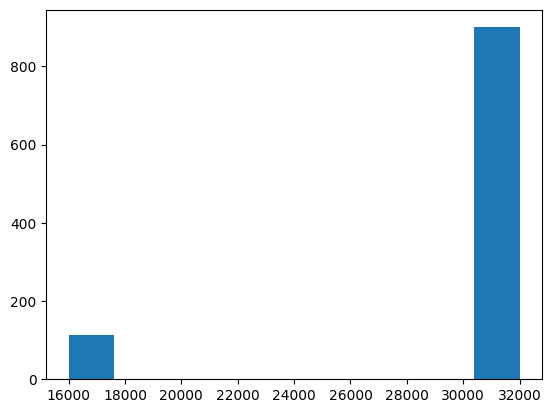

In [5]:
sr_list=[]
for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    sample_rate=sample['audio']['sampling_rate']
    sr_list.append(sample_rate)

plt.hist(sr_list)
plt.show()

For this dataset, we will need to perform some downsampling from 32 000 to 16 000.

In [6]:
from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [7]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [8]:
predictions=[]
references=[]

for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    audio=sample['audio']['array']
    sample_rate=sample['audio']['sampling_rate']
    text=sample['text']

    audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

    input_features = feature_extractor(
    raw_speech=audio,
    sampling_rate=16000,
    return_tensors='pt',
    padding=True).input_features

    # Generate predictions with no gradient computation
    with torch.no_grad():
        op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

    # Decode predictions
    text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

    # Append batch predictions and references to the respective lists
    predictions.extend(text_preds)
    references.extend([text])

  0%|          | 0/1013 [00:00<?, ?it/s]You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 1013/1013 [07:04<00:00,  2.39it/s]


In [9]:
len(predictions),len(references)

(1013, 1013)

In [10]:
wer.compute(predictions=predictions, references=references) * 100

90.40845187588387

In [11]:
text

'algerie two zero seven three proceed direct to trasadingen and continue climb to level two seven zero '

In [12]:
text_preds

[" I'll sherry 2073 Proceed direct to traceting and continue climb to level 270."]

***Results:*** 90% of WER, which is too large.